In [42]:
# load packages
import os
import tempfile
import torch

import planetary_computer
from torch.utils.data import DataLoader

import rioxarray as rxr
import matplotlib.pyplot as plt
from rioxarray.merge import merge_arrays
import geopandas as gpd

from torchgeo.datasets import NAIP, ChesapeakeDE, stack_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

In [2]:
# download NAIP imagery
naip_root = os.path.join(tempfile.gettempdir(), 'naip')
naip_url = (
    'https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/'
)
tiles = [
    'm_3807511_ne_18_060_20181104.tif',
    'm_3807511_se_18_060_20181104.tif',
    'm_3807512_nw_18_060_20180815.tif',
    'm_3807512_sw_18_060_20180815.tif',
]
for tile in tiles:
    url = planetary_computer.sign(naip_url + tile)
    download_url(url, naip_root, filename=tile)

naip = NAIP(naip_root)

Using downloaded and verified file: /var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/naip/m_3807511_ne_18_060_20181104.tif
Using downloaded and verified file: /var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/naip/m_3807511_se_18_060_20181104.tif
Using downloaded and verified file: /var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/naip/m_3807512_nw_18_060_20180815.tif
Using downloaded and verified file: /var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/naip/m_3807512_sw_18_060_20180815.tif


In [3]:
# download corresponding Chesapeake labels
chesapeake_root = os.path.join(tempfile.gettempdir(), 'chesapeake')
os.makedirs(chesapeake_root, exist_ok=True)
chesapeake = ChesapeakeDE(chesapeake_root, crs=naip.crs, res=naip.res, download=True)

In [4]:
# create an intersection dataset that can sample from both datasets simultaneously
dataset = naip & chesapeake

In [5]:
# create random sample
sampler = RandomGeoSampler(dataset, size=1000, length=10)

In [6]:
# create dataloader
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

In [7]:
# explore data
# load one raster into rxr
raster = rxr.open_rasterio(os.path.join(naip_root, tiles[0]))

In [8]:
# check raster
raster

<xarray.DataArray (band: 4, y: 12531, x: 10050)> Size: 504MB
[503746200 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 80kB 4.401e+05 4.401e+05 ... 4.461e+05 4.461e+05
  * y            (y) float64 100kB 4.303e+06 4.303e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      HICKMAN NE 3807511
    TIFFTAG_IMAGEDESCRIPTION:  USDA-FSA-APFO National Agriculture Imagery Pro...
    TIFFTAG_XRESOLUTION:       200
    TIFFTAG_YRESOLUTION:       200
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [9]:
# check band order of naip imagery
naip.bands

('R', 'G', 'B', 'NIR')

In [10]:
# # true color plot of first raster
# raster.sel(band=[1, 2, 3]).plot.imshow()

In [11]:
# load all rasters into list
rasters = []
for tile in tiles:
    path = os.path.join(naip_root, tile)
    rds = rxr.open_rasterio(path)
    rasters.append(rds)

In [12]:
rasters

[<xarray.DataArray (band: 4, y: 12531, x: 10050)> Size: 504MB
 [503746200 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 32B 1 2 3 4
   * x            (x) float64 80kB 4.401e+05 4.401e+05 ... 4.461e+05 4.461e+05
   * y            (y) float64 100kB 4.303e+06 4.303e+06 ... 4.296e+06 4.296e+06
     spatial_ref  int64 8B 0
 Attributes:
     TIFFTAG_DOCUMENTNAME:      HICKMAN NE 3807511
     TIFFTAG_IMAGEDESCRIPTION:  USDA-FSA-APFO National Agriculture Imagery Pro...
     TIFFTAG_XRESOLUTION:       200
     TIFFTAG_YRESOLUTION:       200
     TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
     AREA_OR_POINT:             Area
     scale_factor:              1.0
     add_offset:                0.0,
 <xarray.DataArray (band: 4, y: 12716, x: 10059)> Size: 512MB
 [511640976 values with dtype=uint8]
 Coordinates:
   * band         (band) int64 32B 1 2 3 4
   * x            (x) float64 80kB 4.4e+05 4.4e+05 4.4e+05 ... 4.46e+05 4.46e+05
   * y            (y) float64 102kB 4.297e+06 

In [13]:
# merge rasters
merged = merge_arrays(rasters, method='first')
merged

<xarray.DataArray (band: 4, y: 24242, x: 19245)> Size: 2GB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 154kB 4.4e+05 4.4e+05 ... 4.515e+05 4.515e+05
  * y            (y) float64 194kB 4.303e+06 4.303e+06 ... 4.289e+06 4.289e+06
  * band         (band) int64 32B 1 2 3 4
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_DOCUMENTNAME:      HICKMAN NE 3807511
    TIFFTAG_IMAGEDESCRIPTION:  USDA-FSA-APFO National Agriculture Imagery Pro...
    TIFFTAG_XRESOLUTION:       200
    TIFFTAG_YRESOLUTION:       200
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0

In [14]:
# # plot true color
# merged.sel(band=[1, 2, 3]).plot.imshow(robust=True)

In [15]:
# # plot true color all rasters separate
# fig, axes = plt.subplots(1, 4)
# fig.set_size_inches(15,3)
# for index, ax in enumerate(axes.flat):
#     da = rasters[index].sel(band=[1, 2, 3])
#     im = da.plot.imshow(ax=ax, cmap='Greys_r')
#     filename = tiles[index]
#     ax.set_title(filename)
#     ax.set_aspect('equal') # maintain aspect ratio

# plt.tight_layout()
# plt.show()

In [16]:
# now lets explore the vector data (labels)
# load all rasters into list
rasters_c = []
for tile in chesapeake.files:
    rds = rxr.open_rasterio(tile)
    rasters_c.append(rds)


In [54]:
geo = list(merged.rio.bounds())
geo[0]

440002.8

In [52]:
merged.rio.crs

CRS.from_epsg(26918)

In [55]:
# clip labels to bounds of test rasters
labels = rasters_c[0].rio.clip_box(geo[0], geo[1], geo[2], geo[3], crs=merged.rio.crs)

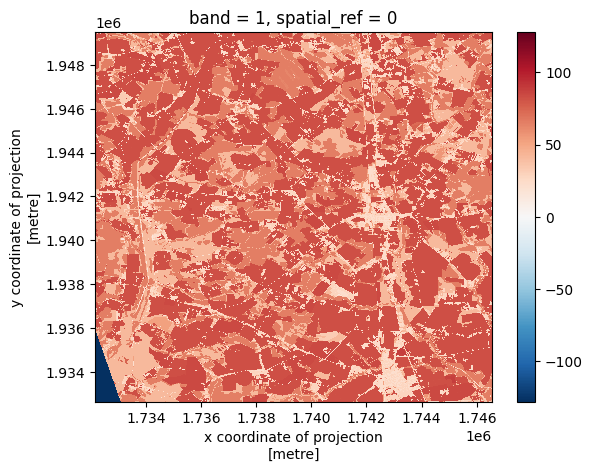

In [57]:
labels.plot()